In [1]:
import os
import os.path as osp
import json
import tempfile
from cvutils.mrcnn.session import init_keras_session
from celldom.preprocessing import apartment_extraction, cell_extraction
from celldom.application import cell_quantification
from celldom.dataset import marker_dataset
from cvutils.mrcnn import model as mrcnn_model
from celldom.config import cell_config, marker_config
from skimage import io as sk_io
from celldom import seed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras

init_keras_session()
plt.gray()
run_name = '20180615'

chip_config_path = osp.join(os.environ['CELLDOM_REPO_DIR'], 'config', 'chip_01_config.json')
digit_model_path = osp.join(os.environ['CELLDOM_DATA_DIR'], 'model', 'r0.2', 'digit_model', 'tune', 'single_digit_model.h5')
cell_model_path = osp.join(os.environ['CELLDOM_DATA_DIR'], 'model', 'r0.2', 'cell_model', 'cell_model.h5')
marker_model_path = osp.join(os.environ['CELLDOM_DATA_DIR'], 'model', 'r0.2', 'marker_model', 'marker_model.h5')
data_dir = osp.join(os.environ['CELLDOM_DATA_DIR'], 'dataset', 'dataset03')
result_dir = osp.join(os.environ['CELLDOM_DATA_DIR'], 'result', 'r0.2', 'cell_quantification', run_name)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
chip_config = json.load(open(chip_config_path, 'r'))

In [3]:
import imp
imp.reload(cell_extraction)
imp.reload(cell_quantification)
imp.reload(apartment_extraction)

<module 'celldom.preprocessing.apartment_extraction' from '/lab/repos/celldom/python/source/celldom/preprocessing/apartment_extraction.py'>

In [4]:
digit_model = keras.models.load_model(digit_model_path)

marker_model = mrcnn_model.get_model(
    'inference', marker_config.MarkerInferenceConfig(), tempfile.mkdtemp(), 
    init_with='file', file=marker_model_path
)

cell_model = mrcnn_model.get_model(
    'inference', cell_config.CellInferenceConfig(), tempfile.mkdtemp(), 
    init_with='file', file=cell_model_path
)

In [5]:
data_files = cell_quantification.get_dataset_files(data_dir, pattern='2018*MOLM13*Chip2/*.tif')
data_files.head()

,address,cells,chip,cohort,conc,date,day,filename,folder,path,z
6,BF_ST_000_APT_000,MOLM13,Chip2,NoDrug,1Mperml,201805311610,20180531,BF_ST_000_APT_000_z_0.tif,2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2,/lab/data/celldom/dataset/dataset03/2018.05.31...,z_0
0,BF_ST_000_APT_000,MOLM13,Chip2,NoDrug,1Mperml,201805311610,20180531,BF_ST_000_APT_000_zm3.tif,2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2,/lab/data/celldom/dataset/dataset03/2018.05.31...,zm3
1,BF_ST_000_APT_000,MOLM13,Chip2,NoDrug,1Mperml,201805311610,20180531,BF_ST_000_APT_000_zm6.tif,2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2,/lab/data/celldom/dataset/dataset03/2018.05.31...,zm6
2,BF_ST_000_APT_000,MOLM13,Chip2,NoDrug,1Mperml,201805311610,20180531,BF_ST_000_APT_000_zm9.tif,2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2,/lab/data/celldom/dataset/dataset03/2018.05.31...,zm9
3,BF_ST_000_APT_000,MOLM13,Chip2,NoDrug,1Mperml,201805311610,20180531,BF_ST_000_APT_000_zp3.tif,2018.05.31.1610 MOLM13 NoDrug 1Mperml Chip2,/lab/data/celldom/dataset/dataset03/2018.05.31...,zp3


In [6]:
import tqdm

def process(record, save_images=False):
    # Prepare single image dataset
    dataset = marker_dataset.MarkerDataset()
    dataset.initialize([record['path']])
    dataset.prepare()
    image = dataset.load_image(0)
    
    # Extract all relevant information
    partitions, norm_image, norm_centers, neighbors, rotation, scale = apartment_extraction.extract(
        image, marker_model, chip_config, 
        digit_model=digit_model, cell_model=cell_model, 
        chip_scaling=False
    )
    
    res = []
    for partition in partitions:
        r = record.copy()
        r['apt_num'] = partition['apartment_num_digits']
        r['apt_num_score'] = partition['apartment_num_digit_scores']
        r['st_num'] = partition['street_num_digits']
        r['st_num_score'] = partition['street_num_digit_scores']
        r['cells'] = partition['cells']
        r['cell_count'] = len(partition['cells'])
        if save_images:
            r['apt_num_image'] = partition['apartment_num_image']
            r['st_num_image'] = partition['street_num_image']
        res.append(r)
    return pd.DataFrame(res)
        
def run(data_files, **kwargs):
    res = []
    for i, r in tqdm.tqdm(data_files.iterrows(), total=len(data_files)):
        try:
            res.append(process(r, **kwargs))
        except:
            print('Failed to process raw image record:\n{}'.format(r.to_dict()))
    return pd.concat(res)

### Run Descriptive Sample

In [7]:
#df = process(data_files.iloc[0])
df = run(data_files.sample(1000, random_state=seed), save_images=True)

  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
100%|██████████| 1000/1000 [50:59<00:00,  3.06s/it]


In [22]:
path = osp.join(result_dir, 'chip_data_sample.pkl')
df.to_pickle(path)
print('Chip data sample saved to', path)

Chip data sample saved to /lab/data/celldom/result/r0.2/cell_quantification/20180615/chip_data_sample.pkl


In [9]:
df.head()

,address,cells,chip,cohort,conc,date,day,filename,folder,path,z,apt_num,apt_num_score,st_num,st_num_score,cell_count,apt_num_image,st_num_image
23929,BF_ST_030_APT_018,"[{'location': (26.79605263157895, 98.631578947...",Chip2,NoDrug,1Mperml,201806021725,20180602,BF_ST_030_APT_018_zp6.tif,2018.06.02.1725 MOLM13 NoDrug 1Mperml Chip2,/lab/data/celldom/dataset/dataset03/2018.06.02...,zp6,019,"[1.0, 0.9999994, 1.0]",031,"[1.0, 1.0, 1.0]",12,"[[[117, 117, 117], [121, 121, 121], [122, 122,...","[[[134, 134, 134], [135, 135, 135], [138, 138,..."
23929,BF_ST_030_APT_018,"[{'location': (35.60115606936416, 94.433526011...",Chip2,NoDrug,1Mperml,201806021725,20180602,BF_ST_030_APT_018_zp6.tif,2018.06.02.1725 MOLM13 NoDrug 1Mperml Chip2,/lab/data/celldom/dataset/dataset03/2018.06.02...,zp6,019,"[0.9999976, 0.99999475, 1.0]",030,"[1.0, 1.0, 1.0]",9,"[[[108, 108, 108], [108, 108, 108], [109, 109,...","[[[126, 126, 126], [123, 123, 123], [125, 125,..."
23929,BF_ST_030_APT_018,"[{'location': (279.8324324324324, 119.61081081...",Chip2,NoDrug,1Mperml,201806021725,20180602,BF_ST_030_APT_018_zp6.tif,2018.06.02.1725 MOLM13 NoDrug 1Mperml Chip2,/lab/data/celldom/dataset/dataset03/2018.06.02...,zp6,011,"[1.0, 1.0, 0.93008184]",030,"[1.0, 1.0, 1.0]",14,"[[[130, 130, 130], [126, 126, 126], [126, 126,...","[[[139, 139, 139], [139, 139, 139], [137, 137,..."
23929,BF_ST_030_APT_018,"[{'location': (31.21764705882353, 97.023529411...",Chip2,NoDrug,1Mperml,201806021725,20180602,BF_ST_030_APT_018_zp6.tif,2018.06.02.1725 MOLM13 NoDrug 1Mperml Chip2,/lab/data/celldom/dataset/dataset03/2018.06.02...,zp6,018,"[1.0, 0.9999995, 0.57199115]",031,"[1.0, 1.0, 1.0]",7,"[[[138, 138, 138], [141, 141, 141], [141, 141,...","[[[138, 138, 138], [140, 140, 140], [140, 140,..."
23929,BF_ST_030_APT_018,"[{'location': (26.18032786885246, 138.64754098...",Chip2,NoDrug,1Mperml,201806021725,20180602,BF_ST_030_APT_018_zp6.tif,2018.06.02.1725 MOLM13 NoDrug 1Mperml Chip2,/lab/data/celldom/dataset/dataset03/2018.06.02...,zp6,020,"[1.0, 1.0, 1.0]",030,"[1.0, 1.0, 1.0]",8,"[[[93, 93, 93], [94, 94, 94], [91, 91, 91], [9...","[[[112, 112, 112], [113, 113, 113], [112, 112,..."


In [10]:
len(df)

12093

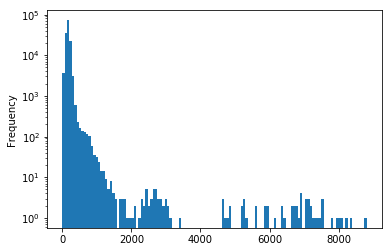

In [29]:
areas = df['cells'].apply(lambda v: [c['area'] for c in v]).tolist()
areas = [a for l in areas for a in l]
pd.Series(areas).plot(kind='hist', bins=128, log=True)

In [23]:
# View some sample apt/st classifications

# from mrcnn import visualize as mrcnn_viz
# n = 32
# df_samp = df.sample(n)
# mrcnn_viz.display_images(df_samp['st_num_image'], df_samp['st_num'], cols=8)
# #mrcnn_viz.display_images(df_samp['apt_num_image'], df_samp['apt_num'], cols=8)

In [17]:
# path = osp.join(os.environ['CELLDOM_REPO_DIR'], 'python/notebook/processing/digits/result/st_num_example.png')
# plt.savefig(path)
# path

In [18]:
df.groupby(['date', 'cohort'])['cell_count'].describe().sort_index()

,,count,mean,std,min,25%,50%,75%,max
date,cohort,,,,,,,,
201805311610,NoDrug,669.0,3.363229,1.571040,0.0,2.0,3.0,4.0,11.0
201805311723,1nMQuiz,692.0,3.803468,1.626157,0.0,3.0,4.0,5.0,11.0
201805312109,NoDrug,692.0,3.872832,1.485487,0.0,3.0,4.0,5.0,15.0
201805312215,1nMQuiz,736.0,3.896739,1.401725,0.0,3.0,4.0,5.0,9.0
201806011045,NoDrug,605.0,4.953719,1.550851,1.0,4.0,5.0,6.0,14.0
201806011129,1nMQuiz,860.0,4.779070,1.314389,0.0,4.0,5.0,5.0,18.0
201806011622,NoDrug,789.0,5.770596,1.828802,0.0,5.0,5.0,7.0,14.0
201806011710,1nMQuiz,725.0,4.656552,1.500222,0.0,4.0,5.0,5.0,14.0
201806012307,NoDrug,775.0,7.180645,2.727672,0.0,5.0,7.0,9.0,22.0


### Debugging

In [47]:
# dataset = marker_dataset.MarkerDataset()
# dataset.initialize(data_files['path'].values)
# dataset.prepare()
# partitions, norm_image, norm_centers, neighbors, rotation, scale = apartment_extraction.extract(
#     image, marker_model, chip_config, 
#     digit_model=digit_model, cell_model=cell_model, 
#     chip_scaling=False
# )

In [34]:
#apartment_extraction.visualize_partition(partitions[0])